In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

llm = ChatOpenAI(model="gpt-4.1-mini")
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = InMemoryVectorStore(embeddings)

### Indexing

In [33]:
# Loading documents

import bs4
from langchain_community.document_loaders import WebBaseLoader, SQLDatabaseLoader

bs4_strainer = bs4.SoupStrainer(class_=("post-content", "post-title", "post-header"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(parse_only=bs4_strainer)
)

docs = loader.load()
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In
{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}


In [15]:
# Splitting documents

from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1_000,
    chunk_overlap=200,
    add_start_index=True
)
all_splits = text_splitter.split_documents(docs)
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [16]:
# Storing documents

document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['60a1a672-21bd-4c1a-9fb7-61e38218ac0b', 'a266397e-fbac-42c2-8c70-f998d9f8093a', 'e9b9c4bc-505b-4af2-96b8-3ecf6ed9d120']


### Retrieval and Generation

In [27]:
from langchain import hub

# using rag prompt from hub
prompt = hub.pull("rlm/rag-prompt")

# custom prompt
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always using Korean.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

print(example_messages[0].content)

Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer and using Korean.

(context goes here)

Question: (question goes here)

Helpful Answer:


In [29]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document


# State
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Nodes
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [30]:
# Control flow

from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

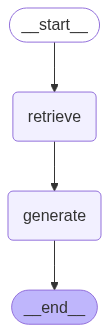

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
# Usage

result = graph.invoke({"question": "Decomposition 작업이 뭐야?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='ffa3cd26-2583-4e1a-8037-cd1bcf516475', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool,

In [26]:
# Stream steps

for step in graph.stream({"question": "Decomposition 작업이 뭐야?"}, stream_mode="updates"):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='ffa3cd26-2583-4e1a-8037-cd1bcf516475', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to a